# Analysis of Medicare Expenditure & Associated Metrics using GridDB

## A Short Note on Medicare

Initiated in 1965, <b> Medicare </b> is one of the most revolutionary plans initiated by the the United States' National Health Insurance Program. Medicare was created to provide equal and adequate access to healthcare for senior citizens of the United States. Though the insurance is primarily offered to citizens aged 65 and older, it is also offered for younger people with disability, including those with chronic end-stage life conditions. Medicare coverage includes four parts - Part A, Part B, Part C and Part D. Read more about each of these coverages <a href = "https://www.medicare.gov/basics/get-started-with-medicare/medicare-basics/parts-of-medicare"> here. </a> To read more on claim types, refer to this <a href = "https://resdac.org/cms-data/variables/nch-claim-type-code"> resource </a>.

<div>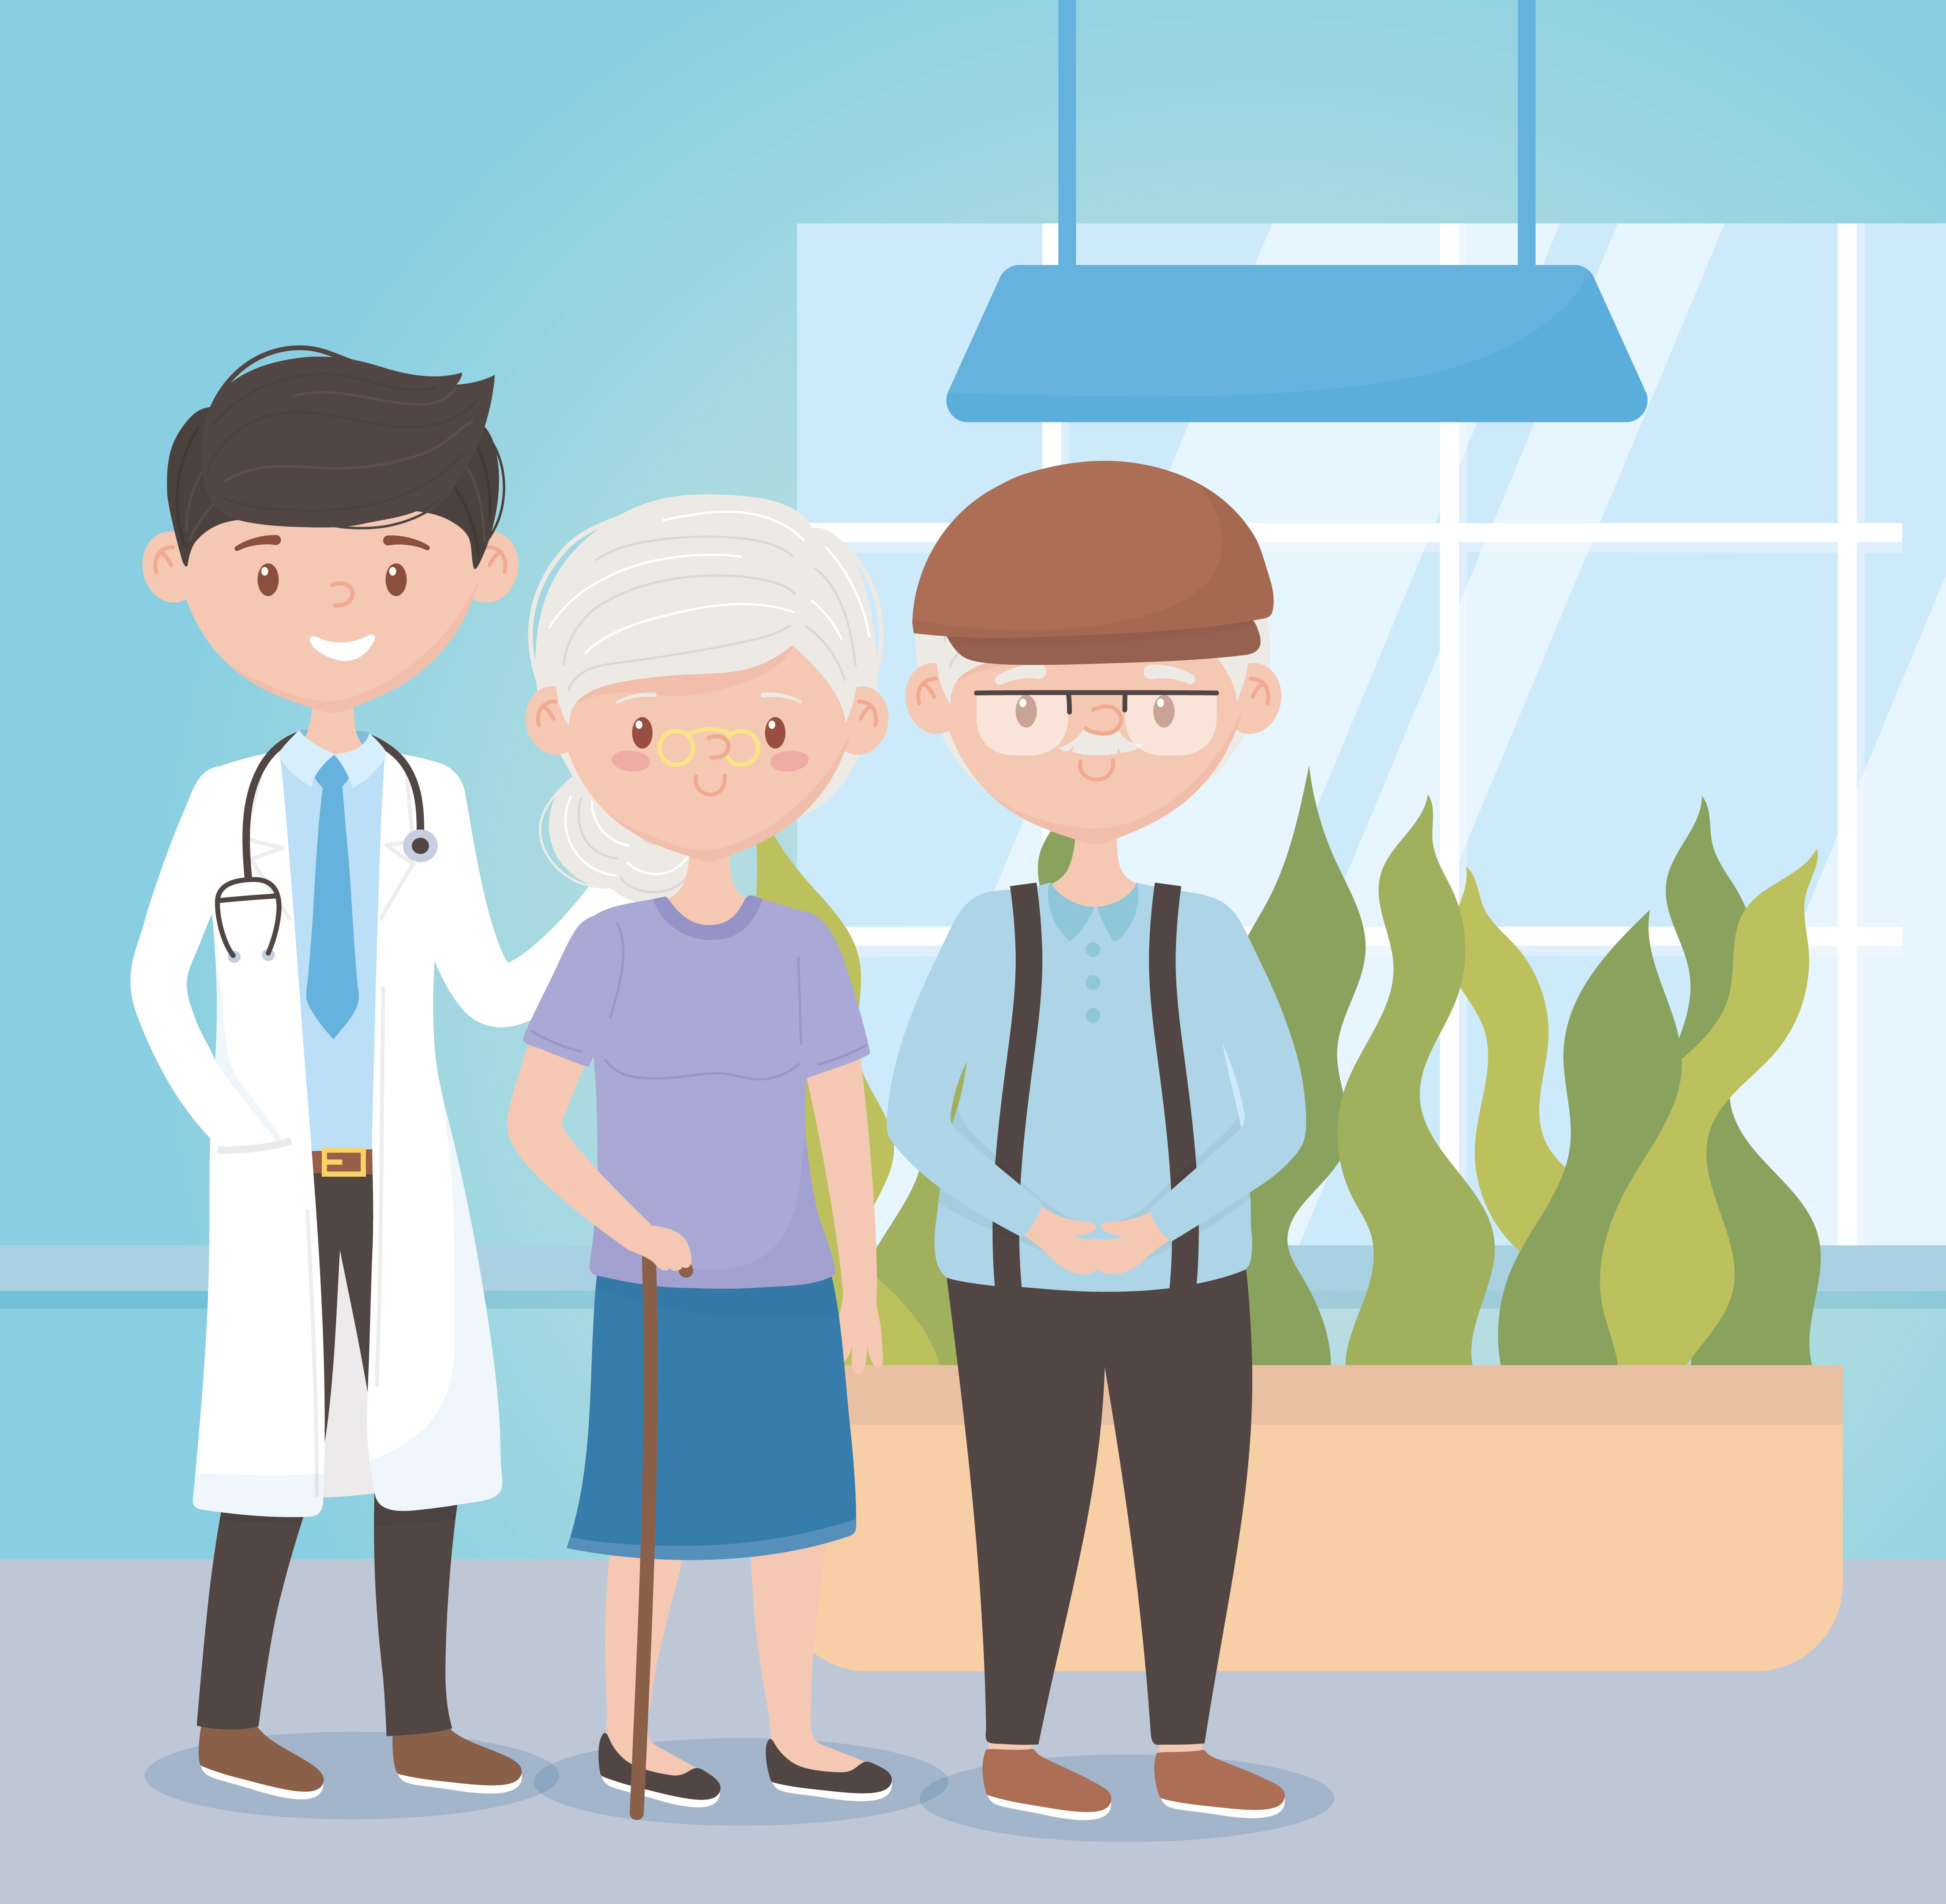</div> 
<center> Image Courtesy: Designed by <a href = "https://www.vecteezy.com/members/stockgiu">stockgiu </a> on <a href="https://www.vecteezy.com/free-vector/medicare">Vecteezy</a></center>

## Objectives of the Analysis

There are several open source datasets related to Medicare available for research. Such datasets have been gathered and analyzed as part of this analysis to get a general idea of the demographics and associated metrics like spending, annual spending per user, and so on. Some of these datasets have data as of 2022 whereas some do not. However, though some data is not up-to-date, it still makes sense to use the information to get insights. Details of each dataset has been explained in the section below. We load these datasets into GridDB in order to use GridDB's fast query engine and then visualize the results using the Altair and Matplotlib libraries in Python.

## About the Datasets

<b> Dataset 1 - </b> <br> 
Dataset 1 is obtained from the <a href = "https://www.ssa.gov/open/data/Data-about-Extra-Help-with-Medicare-Prescription-Drug-Plan-Cost.html"> Social Security Administration.</a> This dataset provides details on decisions made by the Social Security Administration (SSA) for the Medicare Prescription Drug Program (Part D). Note that this data excludes individuals who applied through a State Medicaid agency or who automatically qualified because they were already receiving SSI benefits or Medicaid. There are 2 datasets to be downloaded in this case; one for 2016 - 2022, and another for 2010-2015. <br>
<b> Filenames: </b> fy16-onwards-MPD-Plan-Cost-Yrly.xls and Extra-Help-with-Medicare-Prescription-Drug-Plan-Cost.xls

<b> Dataset 2 - </b> <br> 
The second part of the data is sourced from Data.World. This data offers an interesting compilation of medicare hospital expenditure. For more details on the dataset, refer https://data.world/health/medicare-hospital-spending. <br>
<b> Filenames: </b> rows.csv (This was renamed to Medicare_Hospital_Spending)

<b> Dataset 3 - </b> <br> 
The third part of the data is sourced from the <a href = "https://catalog.data.gov/dataset/medicare-part-d-spending-by-drug-401d2"> Centers for Medicare & Medicaid Services. </a> This data provides drug spending metrics as part of the Part D Medicare program. <br>
<b> Filenames: </b> DSD_PTD_R21_P04_V21_D20_BGM.csv (This was renamed to Drug_Spending_Metrics_PartD)


<b> Dataset 4 - </b> <br> 
The fourth part of the data is sourced from <a href = "https://data.world/carlvlewis/medicare-rx-spending-10-15"> Data.world </a> and provides a detailed compilation of prescription drug spending as part of both the Medicare Part B and Medicare Part D. <br>Note that there are two methods to download the data file - <br>
<ul><li> Click on the download icon next to the name of the file (health-medicare-drug-spending (1).csv) </li>
    <li> Click on the Download hyperlink in the "About this dataset" section next to the size. </li>
</ul>
I used the first option above to download the file by clicking on the download icon. As each of these options provide datasets in different formats, the instructions below only apply when the dataset file is downloaded via the first option above. <br>
<b> Filenames: </b> health-medicare-drug-spending.csv (renamed from health-medicare-drug-spending (1).csv)

## Loading Libraries

In [30]:
import os
os.chdir("C:\\Users\\Python_GRidDB")
import numpy as np
import pandas as pd
from seaborn import countplot
import matplotlib.pyplot as plt
import altair as alt
from vega_datasets import data
import requests  # to make http calls
import http
http.client.HTTPConnection.debuglevel = 1
import json

# Data Cleaning

In [15]:
#Dataset 1
Presc_Drug_cost_2010to2015 = pd.read_excel("Extra-Help-with-Medicare-Prescription-Drug-Plan-Cost.xlsx",skiprows=4,keep_default_na=False)
Presc_Drug_cost_2016to2022 = pd.read_excel("fy16-onwards-MPD-Plan-Cost-Yrly.xlsx",keep_default_na=False)

#Handling Data Formatting Issues 
#drop extra column
Presc_Drug_cost_2016to2022 = Presc_Drug_cost_2016to2022.drop(columns=['Unnamed: 5'])
#rename columns to match the earlier dataset
Presc_Drug_cost_2016to2022 = Presc_Drug_cost_2016to2022.rename(columns={"State (Field A)": "State", "Decisions Made (Field B)": "Decisions Made","Eligible (Field C)": "Eligible","Percentage Eligible (Field D)":"Percentage Eligible"})
#format the Fiscal Year column values
Presc_Drug_cost_2016to2022['Fiscal Year'] = Presc_Drug_cost_2016to2022['Fiscal Year'].str.replace('FY - ','')

#Append the 2 datasets together into one dataframe
Pres_Drug_Costs = Presc_Drug_cost_2010to2015.append(Presc_Drug_cost_2016to2022,ignore_index=True)

C:\Users\mg_su\AppData\Local\Temp/ipykernel_104016/464606998.py:14: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  Pres_Drug_Costs = Presc_Drug_cost_2010to2015.append(Presc_Drug_cost_2016to2022,ignore_index=True)


In [16]:
#Dataset 2
Medicare_Hospital_Spending = pd.read_csv("Medicare_Hospital_Spending.csv")
Medicare_Hospital_Spending.head(n=2)
# We remove currency and percentage symbols from columns
# Removing '$' and '%' from individual columns
Medicare_Hospital_Spending["Avg Spending Per Episode (Hospital)"] = Medicare_Hospital_Spending["Avg Spending Per Episode (Hospital)"].str.replace("$","")
Medicare_Hospital_Spending["Avg Spending Per Episode (State)"] = Medicare_Hospital_Spending["Avg Spending Per Episode (State)"].str.replace("$","")
Medicare_Hospital_Spending["Avg Spending Per Episode (Nation)"] = Medicare_Hospital_Spending["Avg Spending Per Episode (Nation)"].str.replace("$","")
Medicare_Hospital_Spending["Percent of Spending (Hospital)"] = Medicare_Hospital_Spending["Percent of Spending (Hospital)"].str.replace("%","")
Medicare_Hospital_Spending["Percent of Spending (State)"] = Medicare_Hospital_Spending["Percent of Spending (State)"].str.replace("%","")
Medicare_Hospital_Spending["Percent of Spending (Nation)"] = Medicare_Hospital_Spending["Percent of Spending (Nation)"].str.replace("%","")

#Dataset 3
#Here, we transform the dataframe which is in a wide format to a long format. We introduce a column named 'metric'
# while transforming the values in the columns Avg_Spnd_Per_Dsg_Unt_Wghtd_2016, Avg_Spnd_Per_Dsg_Unt_Wghtd_2017, etc. to rows.  
PartD_Drug_Spending_Metrics = pd.read_csv("Drug_Spending_Metrics_PartD.csv")
PartD_Drug_Spending_Metrics = PartD_Drug_Spending_Metrics[PartD_Drug_Spending_Metrics.Mftr_Name!='Overall']
PartD_Drug_Spending_Metrics = PartD_Drug_Spending_Metrics.drop(columns=[
'Avg_Spnd_Per_Dsg_Unt_Wghtd_2016', 'Avg_Spnd_Per_Clm_2016','Avg_Spnd_Per_Bene_2016','Outlier_Flag_2016',
'Avg_Spnd_Per_Dsg_Unt_Wghtd_2017', 'Avg_Spnd_Per_Clm_2017','Avg_Spnd_Per_Bene_2017','Outlier_Flag_2017',
'Avg_Spnd_Per_Dsg_Unt_Wghtd_2018', 'Avg_Spnd_Per_Clm_2018','Avg_Spnd_Per_Bene_2018','Outlier_Flag_2018',
'Avg_Spnd_Per_Dsg_Unt_Wghtd_2019', 'Avg_Spnd_Per_Clm_2019','Avg_Spnd_Per_Bene_2019','Outlier_Flag_2019',
'Avg_Spnd_Per_Dsg_Unt_Wghtd_2020', 'Avg_Spnd_Per_Clm_2020','Avg_Spnd_Per_Bene_2020','Outlier_Flag_2020'        
])
PartD_Drug_Spending=pd.melt(PartD_Drug_Spending_Metrics,id_vars=['Brnd_Name','Gnrc_Name','Tot_Mftr','Mftr_Name'],var_name='metrics', value_name='values')


#Dataset 4
health_medicare_drug_spending = pd.read_csv("health-medicare-drug-spending.csv")
health_medicare_drug_spending["beneficiary_count_lis"] = health_medicare_drug_spending["beneficiary_count_lis"].str.replace(",","")
health_medicare_drug_spending["beneficiary_count_no_lis"] = health_medicare_drug_spending["beneficiary_count_no_lis"].str.replace(",","")
health_medicare_drug_spending["beneficiary_count_lis"] = pd.to_numeric(health_medicare_drug_spending["beneficiary_count_lis"])
health_medicare_drug_spending["beneficiary_count_lis"] = health_medicare_drug_spending["beneficiary_count_no_lis"].fillna(0).astype(int)
health_medicare_drug_spending["beneficiary_count_no_lis"] = pd.to_numeric(health_medicare_drug_spending["beneficiary_count_no_lis"])

C:\Users\mg_su\AppData\Local\Temp/ipykernel_104016/3553379346.py:6: FutureWarning: The default value of regex will change from True to False in a future version. In addition, single character regular expressions will *not* be treated as literal strings when regex=True.
  Medicare_Hospital_Spending["Avg Spending Per Episode (Hospital)"] = Medicare_Hospital_Spending["Avg Spending Per Episode (Hospital)"].str.replace("$","")
C:\Users\mg_su\AppData\Local\Temp/ipykernel_104016/3553379346.py:7: FutureWarning: The default value of regex will change from True to False in a future version. In addition, single character regular expressions will *not* be treated as literal strings when regex=True.
  Medicare_Hospital_Spending["Avg Spending Per Episode (State)"] = Medicare_Hospital_Spending["Avg Spending Per Episode (State)"].str.replace("$","")
C:\Users\mg_su\AppData\Local\Temp/ipykernel_104016/3553379346.py:8: FutureWarning: The default value of regex will change from True to False in a future v

## Creating the Request & Containers

We create the request and containers.

In [17]:
#Construct an object to hold the request headers (ensure that you replace the XXX placeholder with the correct value that matches the credentials for your GridDB instance)
header_obj = {"Authorization":"XXX","Content-Type":"application/json; charset=UTF-8","User-Agent":"PostmanRuntime/7.29.0"}

#Construct the base URL based on your GRIDDB cluster you'd like to connect to (ensure that you replace the placeholders in the URL below with the correct values that correspond to your GridDB instance)
# Add the appropriate host, port, cluster and database name in the base_url
base_url = 'https://[host]:[port]/griddb/v2/[clustername]/dbs/[database_name]'

### Creating the container Pres_Drug_Costs

In [ ]:
#Construct an object to hold the request body (i.e., the container that needs to be created)

data_obj = {
    "container_name": "Pres_Drug_Costs",
    "container_type": "COLLECTION",
    "rowkey": False,
    "columns": [
    {
    "name": "fiscal_year",
    "type": "INTEGER"
    },
    {
    "name": "state",
    "type": "STRING"
    },
    {
    "name": "Decisions_Made",
    "type": "INTEGER"
    },
    {
    "name": "Eligible",
    "type": "INTEGER"
    },
    {
    "name": "Percentage_Eligible",
    "type": "FLOAT"
    }
    ]
}

#Set up the GridDB WebAPI URL
url = base_url + '/containers'

#Invoke the GridDB WebAPI with the headers and the request body
x = requests.post(url, json = data_obj, headers = header_obj)

### Creating the container Medicare_Hospital_Spending

In [ ]:
#Construct an object to hold the request body (i.e., the container that needs to be created)

data_obj = {
    "container_name": "Medicare_Hospital_Spending",
    "container_type": "COLLECTION",
    "rowkey": False,
    "columns": [
    {
    "name": "hospital_name",
    "type": "STRING"
    },
    {
    "name": "provider_number",
    "type": "STRING"
    },
    {
    "name": "state",
    "type": "STRING"
    },
    {
    "name": "period",
    "type": "STRING"
    },
    {
    "name": "claim_type",
    "type": "STRING"
    },
    {
    "name": "avg_spending_per_episode_hospital",
    "type": "FLOAT"
    },  
    {
    "name": "avg_spending_per_episode_state",
    "type": "FLOAT"
    },
    {
    "name": "avg_spending_per_episode_nation",
    "type": "FLOAT"
    }, 
    {
    "name": "percent_of_spending_hospital",
    "type": "FLOAT"
    }, 
    {
    "name": "percent_of_spending_state",
    "type": "FLOAT"
    }, 
    {
    "name": "percent_of_spending_nation",
    "type": "FLOAT"
    },
    {
    "name": "measure_start_date",
    "type": "STRING"
    },
    {
    "name": "measure_end_date",
    "type": "STRING"
    }        
    ]
}

#Set up the GridDB WebAPI URL
url = base_url + '/containers'

#Invoke the GridDB WebAPI with the headers and the request body
x = requests.post(url, json = data_obj, headers = header_obj)

### Creating the Container PartD_Drug_Spending_Metrics

In [ ]:
#Construct an object to hold the request body (i.e., the container that needs to be created)

#"1st Tier Unifine Pentips","Pen Needle, Diabetic",1,"Owen Mumford Us","Tot_Spndng_2016",216273.87

data_obj = {
    "container_name": "PartD_Drug_Spending",
    "container_type": "COLLECTION",
    "rowkey": False,
    "columns": [
    {
    "name": "Brnd_Name",
    "type": "STRING"
    },
    {
    "name": "Gnrc_Name",
    "type": "STRING"
    },        
    {
    "name": "Tot_Mftr",
    "type": "INTEGER"
    },
    {
    "name": "Mftr_Name",
    "type": "STRING"
    },
    {
    "name": "metrics",
    "type": "STRING"
    },
    {
    "name": "values",
    "type": "FLOAT"
    }       
    ]
}

#Set up the GridDB WebAPI URL
url = base_url + '/containers'

#Invoke the GridDB WebAPI with the headers and the request body
x = requests.post(url, json = data_obj, headers = header_obj)

### Creating the Container health_medicare_drug_spending

In [ ]:
#Construct an object to hold the request body (i.e., the container that needs to be created)

data_obj = {
    "container_name": "health_medicare_drug_spending",
    "container_type": "COLLECTION",
    "rowkey": False,
    "columns": [
    {
    "name": "year",
    "type": "INTEGER"
    },
    {
    "name": "brand_name",
    "type": "STRING"
    },
    {
    "name": "generic_name",
    "type": "STRING"
    },
    {
    "name": "coverage_type",
    "type": "STRING"
    },
    {
    "name": "total_spending",
    "type": "FLOAT"
    },
    {
    "name": "beneficiary_count",
    "type": "INTEGER"
    },  
    {
    "name": "unit_count",
    "type": "INTEGER"
    },
    {
    "name": "beneficiary_cost_share",
    "type": "FLOAT"
    }, 
    {
    "name": "total_annual_spending_per_user",
    "type": "FLOAT"
    }, 
    {
    "name": "average_cost_per_unit",
    "type": "FLOAT"
    }, 
    {
    "name": "average_annual_beneficiary_cost_share",
    "type": "FLOAT"
    },
    {
    "name": "claim_count",
    "type": "INTEGER"
    },
    {
    "name": "beneficiary_count_lis",
    "type": "INTEGER"
    },
    {
    "name": "beneficiary_count_no_lis",
    "type": "FLOAT"
    },
    {
    "name": "beneficiary_cost_share_lis",
    "type": "FLOAT"
    },
    {
    "name": "beneficiary_cost_share_no_lis",
    "type": "FLOAT"
    },
   {
    "name": "average_beneficiary_cost_share_lis",
    "type": "FLOAT"
    },
    {
    "name": "average_beneficiary_cost_share_no_lis",
    "type": "FLOAT"
    },
    {
    "name": "serialid",
    "type": "INTEGER"
    }    
    ]
}

#Set up the GridDB WebAPI URL
url = base_url + '/containers'

#Invoke the GridDB WebAPI with the headers and the request body
x = requests.post(url, json = data_obj, headers = header_obj)

## Loading Data into the containers in GridDB (Row Registration)

### Loading the container 'Pres_Drug_Costs'

In [56]:
#Convert the data in the dataframe to the JSON format
Pres_Drug_Costs_json = Pres_Drug_Costs.to_json(orient='values')
request_body_Pres_Drug_Costs = Pres_Drug_Costs_json

In [ ]:
#Setup the URL to be used to invoke the GridDB WebAPI to register rows in the container created previously
url = base_url + '/containers/Pres_Drug_Costs/rows'

#Invoke the GridDB WebAPI using the request constructed
x = requests.put(url, data=request_body_Pres_Drug_Costs, headers=header_obj)

In [60]:
print(str(json.loads(x.text)['count']) + ' rows have been registered in the container Pres_Drug_Costs.')

687 rows have been registered in the container Pres_Drug_Costs.


### Loading the container 'Medicare_Hospital_Spending'

In [429]:
#Convert the data in the dataframe to the JSON format
Medicare_Hospital_Spending_json = Medicare_Hospital_Spending.to_json(orient='values')
request_body_Medicare_Hospital_Spending = Medicare_Hospital_Spending_json

In [ ]:
#Setup the URL to be used to invoke the GridDB WebAPI to register rows in the container created previously
url = base_url + '/containers/Medicare_Hospital_Spending/rows'

#Invoke the GridDB WebAPI using the request constructed
x = requests.put(url, data=request_body_Medicare_Hospital_Spending, headers=header_obj)

In [431]:
print(str(json.loads(x.text)['count']) + ' rows have been registered in the container Medicare_Hospital_Spending.')

70598 rows have been registered in the container Medicare_Hospital_Spending.


### Loading the Container 'PartD_Drug_Spending'

In [120]:
#Convert the data in the dataframe to the JSON format
PartD_Drug_Spending_json = PartD_Drug_Spending.to_json(orient='values')
request_body_PartD_Drug_Spending_json = PartD_Drug_Spending_json

In [ ]:
#Setup the URL to be used to invoke the GridDB WebAPI to register rows in the container created previously
url = base_url + '/containers/PartD_Drug_Spending/rows'

#Invoke the GridDB WebAPI using the request constructed
x = requests.put(url, data=request_body_PartD_Drug_Spending_json, headers=header_obj)

In [123]:
print(str(json.loads(x.text)['count']) + ' rows have been registered in the container PartD_Drug_Spending.')

219868 rows have been registered in the container PartD_Drug_Spending.


### Loading the Container 'health_medicare_drug_spending'

In [181]:
#Convert the data in the dataframe to the JSON format
health_medicare_drug_spending_json = health_medicare_drug_spending.to_json(orient='values')
request_body_health_medicare_drug_spending_json = health_medicare_drug_spending_json

In [ ]:
#Setup the URL to be used to invoke the GridDB WebAPI to register rows in the container created previously
url = base_url + '/containers/health_medicare_drug_spending/rows'

#Invoke the GridDB WebAPI using the request constructed
x = requests.put(url, data=request_body_health_medicare_drug_spending_json, headers=header_obj)

In [184]:
print(str(json.loads(x.text)['count']) + ' rows have been registered in the container health_medicare_drug_spending.')

576 rows have been registered in the container health_medicare_drug_spending.


## Data Visualization & Insights

### What percentage of applicants are eligible for Extra Help With Medicare Prescription Drug Plan Costs as of 2022 by State?

<b> The Social Security Administration decides the applicants eligible for Prescription Drug costs after analyzing the applications sent to it. </b> Let's dig into this information to understand more about it.

In [18]:
sql_query1 = (f"""SELECT fiscal_year, state, Percentage_Eligible FROM Pres_Drug_Costs where fiscal_year = 2022""")

In [19]:
#Setup the URL to be used to invoke the GridDB WebAPI to retrieve data from the container
url = base_url + '/sql'

#Construct the request body
request_body = '[{"type":"sql-select", "stmt":"'+sql_query1+'"}]'

#Validate the constructed request body
request_body

'[{"type":"sql-select", "stmt":"SELECT fiscal_year, state, Percentage_Eligible FROM Pres_Drug_Costs where fiscal_year = 2022"}]'

In [20]:
#Invoke the GridDB WebAPI
data_req1 = requests.post(url, data=request_body, headers=header_obj)

In [21]:
#Process the response received and construct a Pandas dataframe with the data from the response
myJson = data_req1.json()
Pres_Drug_Eligibility = pd.DataFrame(myJson[0]["results"], columns=[myJson[0]["columns"][0]["name"], myJson[0]["columns"][1]["name"],myJson[0]["columns"][2]["name"]])
Pres_Drug_Eligibility=Pres_Drug_Eligibility.sort_values(by=['Percentage_Eligible'], ascending=False)

In [22]:
df = Pres_Drug_Eligibility[Pres_Drug_Eligibility.state != "No Zip Available"]

Text(0.5, 1.0, 'Percentage of Eligible Applicants by State')

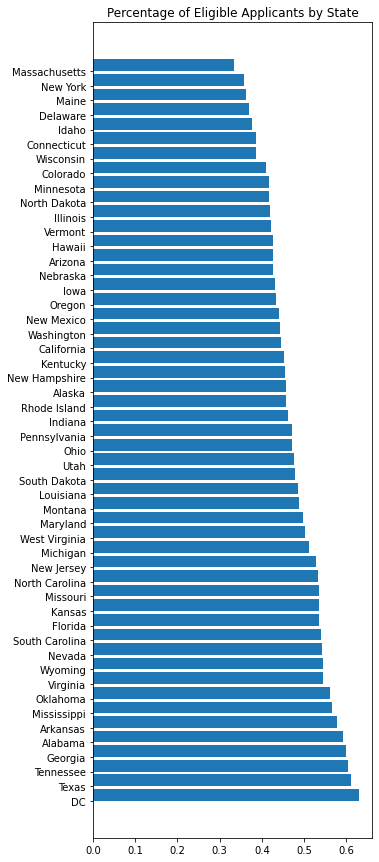

In [23]:
height = df['Percentage_Eligible']
bars = df['state']
y_pos = np.arange(len(bars))
 
f = plt.figure()
f.set_figwidth(5)
f.set_figheight(15)

# Create a horizontal bar chart
plt.barh(bars, width=height, align='edge')

plt.title('Percentage of Eligible Applicants by State', fontdict=None, loc='center')

<b> Insight(s): </b> DC, Texas, Tennesse and Alabama have the highest percentage of applications eligible for extra help with prescription drug costs. 

### What is the Medicare Acceptance Ratio for Prescription Drug Costs as of 2021 and 2022 by State?

For this, we calculate the Medicare Acceptance Ratio for each state and year. The Medicare Acceptance Ratio is calculated as the number of decisions made to the number of applications marked as 'eligible'.  

In [24]:
sql_query1a = (f"""SELECT fiscal_year, state, Decisions_Made, Eligible FROM Pres_Drug_Costs where fiscal_year IN (2021,2022)""")

In [25]:
#Setup the URL to be used to invoke the GridDB WebAPI to retrieve data from the container
url = base_url + '/sql'

#Construct the request body
request_body = '[{"type":"sql-select", "stmt":"'+sql_query1a+'"}]'

#Validate the constructed request body
request_body

'[{"type":"sql-select", "stmt":"SELECT fiscal_year, state, Decisions_Made, Eligible FROM Pres_Drug_Costs where fiscal_year IN (2021,2022)"}]'

In [26]:
#Invoke the GridDB WebAPI
data_req1a = requests.post(url, data=request_body, headers=header_obj)

In [27]:
#Process the response received and construct a Pandas dataframe with the data from the response
myJson = data_req1a.json()
Decisions_vs_Eligibility = pd.DataFrame(myJson[0]["results"], columns=[myJson[0]["columns"][0]["name"], myJson[0]["columns"][1]["name"],myJson[0]["columns"][2]["name"],myJson[0]["columns"][3]["name"]])
Decisions_vs_Eligibility=Decisions_vs_Eligibility.sort_values(by=['Eligible'], ascending=False)

In [28]:
Decisions_vs_Eligibility = Decisions_vs_Eligibility[Decisions_vs_Eligibility['state']!= 'Total'] # Exclude the Total rows

In [29]:
alt.Chart(Decisions_vs_Eligibility).transform_fold(['Decisions_Made','Eligible'],as_=['Medicare Acceptance Ratio','Value']).mark_bar().encode(
    alt.X('state:O', axis=None),#axis=alt.Axis(title=None, labels=False, ticks=False)),
    alt.Y('Value:Q', axis=alt.Axis(grid=True)),
    alt.Facet('fiscal_year:N',title="Medicare Acceptance Ratio for 2021 and 2022 by State",),
    color='Medicare Acceptance Ratio:N',
    tooltip = ['Medicare Acceptance Ratio:N', 'state:N', 'Value:N' ]
).properties(height=800, width=800).configure_view(
    stroke='transparent'
).configure_scale(bandPaddingInner=0,
                  bandPaddingOuter=0.1,
).configure_header(labelOrient='bottom',
                   labelPadding = 3).configure_facet(spacing=5
)

C:\Users\mg_su\anaconda3\lib\site-packages\altair\utils\core.py:317: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  for col_name, dtype in df.dtypes.iteritems():


alt.Chart(...)

<b> Insight(s): </b> <ol> <li> In Texas, the Medicare Acceptance rate is around 0.6. For 5 applications that had a decisions made, 3 of them were found eligible as of 2021 and 2022.</li> <li> Florida, Georgia and California have a high number of applications that come in for the Medicare Part D prescription plan. </li> <li> In Georgia, for every 5 applications, 2 are found to be eligible. </li> <li> In Florida, for 2 applications submitted for a decision, 2 are found eligible.</li> <li> In Georgia, for 2 applications submitted, 1 or both are found eligible. </ol> 

### What is the average spending per Beneficiary for a hospital admission?
### What are the top hospitals by Medicare Spending per Beneficiary?

<b> The average spending levels during hospitals’ Medicare Spending per Beneficiary (MSPB) includes all Part A and Part B claims paid during the period from 3 days prior to a hospital admission through 30 days after discharge. Each event associated with the hospital admission through discharge is referred to as an 'episode'. </b>

In [30]:
sql_query2 = (f"""SELECT hospital_name, avg_spending_per_episode_hospital, percent_of_spending_hospital from Medicare_Hospital_Spending""")

In [31]:
#Setup the URL to be used to invoke the GridDB WebAPI to retrieve data from the container
url = base_url + '/sql'

In [32]:
#Construct the request body
request_body = '[{"type":"sql-select", "stmt":"'+sql_query2+'"}]'

#Validate the constructed request body
request_body

#Invoke the GridDB WebAPI
data_req2 = requests.post(url, data=request_body, headers=header_obj)

In [33]:
#Process the response received and construct a Pandas dataframe with the data from the response
myJson = data_req2.json()
Med_hosp_spending = pd.DataFrame(myJson[0]["results"], columns=[myJson[0]["columns"][0]["name"], myJson[0]["columns"][1]["name"],myJson[0]["columns"][2]["name"]])
Med_hosp_spending=Med_hosp_spending.sort_values(by=['avg_spending_per_episode_hospital'], ascending=False)
Top_15_avg_spending = Med_hosp_spending.nlargest(15, 'avg_spending_per_episode_hospital')
Top_15_avg_spending = Top_15_avg_spending.sort_values(by=['avg_spending_per_episode_hospital'], ascending=False)

In [34]:
source = Top_15_avg_spending

title = alt.TitleParams('Top 15 Hospitals by Average Spending per hospital episode', anchor='middle')

bar = alt.Chart(source,title=title).mark_bar().encode(
    x=alt.X('hospital_name:O',title = 'Hospital'),
    y=alt.Y('avg_spending_per_episode_hospital:Q', title='Avg. Spending per Episode (Hospital)'),
)

rule = alt.Chart(source).mark_rule(color='red').encode(
    y=alt.Y('mean(avg_spending_per_episode_hospital):Q'),

)

(bar + rule).properties(width=600)

C:\Users\mg_su\anaconda3\lib\site-packages\altair\utils\core.py:317: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  for col_name, dtype in df.dtypes.iteritems():


alt.LayerChart(...)

<b> Insight(s) </b>: The Medicare spending per episode is the largest for <b>'Fountation Surgical Hospital of El Paso' at around USD 39,000 </b>. <br>  This is closely followed by Unity Medical and Surgical Hospital and Nebraska Spine Hospital  with a medicare spending of around <b> USD35,000 </b>. <br> The Average Medicare spending across all hospitals is <b> USD 31,000 </b>.

### What is the percent of spending by state for claims such as Inpatient, Skilled Nursing Facility and Carrier claim types?

In this case, we will need to filter the data for 2022. The only 2 columns that can be used include the measure_start_date and measure_end_date. Note that both the columns are string data types in the container 'Medicare_Hospital_Spending'. We will need to extract the year from 'measure_start_date'. We use GridDB's SUBSTR function for this. Refer to the SUBSTR operation supported by GridDB <a href = "https://docs.griddb.net/sqlreference/sql-commands-supported/#character-functions">here</a>. In this case, as the value is of the format MM-DD-YYYY, we will cut the string starting from the 7th character onwards. 

In [35]:
sql_query3 = (f"""SELECT state, SUBSTR(measure_start_date, 7) as start_yr, claim_type, avg(percent_of_spending_state) as percent_spending_state from Medicare_Hospital_Spending where claim_type != 'Total' group by 1,2,3""")

In [36]:
#Setup the URL to be used to invoke the GridDB WebAPI to retrieve data from the container
url = base_url + '/sql'

In [37]:
#Construct the request body
request_body = '[{"type":"sql-select", "stmt":"'+sql_query3+'"}]'

#Validate the constructed request body
request_body

#Invoke the GridDB WebAPI
data_req3 = requests.post(url, data=request_body, headers=header_obj)

In [38]:
#Process the response received and construct a Pandas dataframe with the data from the response
myJson = data_req3.json()
percent_spending_state = pd.DataFrame(myJson[0]["results"], columns=[myJson[0]["columns"][0]["name"], myJson[0]["columns"][1]["name"],myJson[0]["columns"][2]["name"],myJson[0]["columns"][3]["name"]])
percent_spending_state=percent_spending_state.sort_values(by=['percent_spending_state'], ascending=False)

We use the altair library to build a Chloropleth map for this. We use a public dataset available in Altair to make use of the State codes. We also use a state name lookup to get the full forms of states using another data file named 'State Name Lookup'. We use this to construct the Chloropleth. The State Name lookup was sourced from https://abbreviations.yourdictionary.com/articles/state-abbrev.html.
A printable list is provided here. Use the 'State Name' and 'USPS Abbreviation' to create the file. Rename the column names as 'state' and 'State_Name' respectively. Save the same as an xlsx file with name State_Name_Lookup.xlsx.

In [39]:
State_Name_Lookup = pd.read_excel('State_Name_Lookup.xlsx')

In [40]:
State_Name_Dict = dict(zip(State_Name_Lookup.state, State_Name_Lookup.State_Name))

In [41]:
percent_spending_state['State_Name'] = percent_spending_state['state'].map(State_Name_Dict)

In [42]:
#Gathering the state IDs from vega datasets
incresp = requests.get('https://cdn.jsdelivr.net/npm/vega-datasets@v1.29.0/data/income.json')
statejson = pd.DataFrame(incresp.json())
#convert statenames to uppercase
statejson['name'] = statejson['name'].str.upper()

In [43]:
#get the complete state name and then the corresponding ID
state_id_assignment = dict(zip(statejson.name, statejson.id))
percent_spending_state['state_id'] = percent_spending_state['State_Name'].map(state_id_assignment)
#as the state ID is of the float datatype, convert it to the integer datatype
percent_spending_state['state_id'] = percent_spending_state['state_id'].fillna(0).astype(int)

In [44]:
specific_claims_spending = percent_spending_state[percent_spending_state['claim_type'].isin(['Carrier', 'Inpatient', 'Skilled Nursing Facility'])]

In [45]:
states = alt.topo_feature(data.us_10m.url, 'states')
source = specific_claims_spending

chloropleth_spending = alt.Chart(source).mark_geoshape().encode(
    shape='geo:G',
    color = alt.Color('percent_spending_state:Q'),
    tooltip=['percent_spending_state:N', 'State_Name:N'],
    facet=alt.Facet('claim_type:N', columns=2),
).transform_lookup(
    lookup='state_id',
    from_=alt.LookupData(data=states, key='id'),
    as_='geo'
).properties(
    width=400,
    height=400,
    title='Percentage Spending by State and Claim Type'
).project(
    type='albersUsa'
)


chloropleth_spending

C:\Users\mg_su\anaconda3\lib\site-packages\altair\utils\core.py:317: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  for col_name, dtype in df.dtypes.iteritems():


alt.Chart(...)

<b> Note: </b> Hover over the map to access the tooltip and see values.

<b> Insight(s): </b> <ol> <li> The rate of spending for the carrier claim type has been the highest for Arizona, Nevada at 61% and 59% respectively. This is followed by
    Michigan, Illinois, New York, California and Georgia at an average spending of 54%. </li>
    <li> The rate of spending for the Inpatient claim type has been the highest for Nevada, Oregon, Oklahoma and Arkansas at 21%. Almost all states across the United States have an average spending of 19%.</li>

### What does the total spending per user look like (5 year trend)?

In [46]:
sql_query4 = (f"""SELECT generic_name, brand_name, coverage_type, year as spending_year, sum(total_annual_spending_per_user) as total_spending_per_user from health_medicare_drug_spending where year>=2010 group by generic_name, year""")

In [47]:
#Setup the URL to be used to invoke the GridDB WebAPI to retrieve data from the container
url = base_url + '/sql'

#Construct the request body
request_body = '[{"type":"sql-select", "stmt":"'+sql_query4+'"}]'

#Validate the constructed request body
request_body

#Invoke the GridDB WebAPI
data_req4 = requests.post(url, data=request_body, headers=header_obj)

In [48]:
#Process the response received and construct a Pandas dataframe with the data from the response
myJson = data_req4.json()
total_spending_generic = pd.DataFrame(myJson[0]["results"], columns=[myJson[0]["columns"][0]["name"], myJson[0]["columns"][1]["name"],myJson[0]["columns"][2]["name"],myJson[0]["columns"][3]["name"],myJson[0]["columns"][4]["name"]])
Top_10_generic = total_spending_generic.nlargest(10, 'total_spending_per_user')
Top_10_generic

,generic_name,brand_name,coverage_type,spending_year,total_spending_per_user
400,Corticotropin,H.P. Acthar,Part D,2015,162370.937500
130,Treprostinil Sodium,Remodulin,Part B,2011,145481.625000
523,Treprostinil Sodium,Remodulin,Part B,2015,144069.546875
333,Treprostinil Sodium,Remodulin,Part B,2013,141673.750000
287,Treprostinil Sodium,Remodulin,Part B,2012,141147.796875
80,Treprostinil Sodium,Remodulin,Part B,2010,140734.515625
483,Treprostinil Sodium,Remodulin,Part B,2014,133844.656250
360,Corticotropin,H.P. Acthar,Part D,2014,133420.750000
31,Corticotropin,H.P. Acthar,Part D,2013,108013.820312
48,Treprostinil; Treprostinil/Neb Accessories; Tr...,Tyvaso,Part B,2015,107489.132812


In [49]:
title = alt.TitleParams('5-year trend of the Total spending per user', anchor='middle')
source = Top_10_generic

alt.Chart(source, title=title).mark_bar().encode(
    x=alt.X('spending_year:O', title=''),
    y=alt.Y('sum(total_spending_per_user):Q', title='Total spending per user'),
    color=alt.Color('spending_year:N', title=''),
   ).properties(
    width=800,
    height=300
)

C:\Users\mg_su\anaconda3\lib\site-packages\altair\utils\core.py:317: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  for col_name, dtype in df.dtypes.iteritems():


alt.Chart(...)

<b> Insight(s): </b> As you can see, the total spending per user was around USD 150,000 on average from 2010 to 2012. However, from 2013 onwards, there was a steep increase in the total spending per user. In 2012 and 2014, the total spending per user has been around 250,000 on average (2-month average). As of 2015, the total spending per user has increased to almost twice that of 2010 at USD 400,000. 

### What are the top 10 brands by total spending per user between 2011 and 2015?

While trying to find the Top 10 brands, it is important to find the brands that have been consistently at the top between 2011 and 2015. Doing a 'Limit 10' alone will not suffice, as it will just return the top brands that have had top sales in one of the years and for one of the coverage types available. Hence, a subquery needs to be written to get insight into the top 10 brands. GridDB supports standard SQL subqueries. To read more on it, refer to this <a href = "https://docs.griddb.net/sqlreference/sql-commands-supported/#subquery"> resource. </a> 

Below is the subquery to be used-

SELECT a1.generic_name, a1.brand_name, a1.coverage_type, a1.year as spending_year, sum(a1.total_annual_spending_per_user) as total_spending_per_user <br>
FROM health_medicare_drug_spending a1 <br>
WHERE a1.brand_name in <br>
	&nbsp;&nbsp;&nbsp;&nbsp;(SELECT brand_name <br>
	&nbsp;&nbsp;&nbsp;&nbsp;FROM <br>
    &nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;(<br>
		&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;SELECT brand_name, sum(total_annual_spending_per_user) totspend, count(*) cnt <br>
		&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;FROM health_medicare_drug_spending <br>
		&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;WHERE year>=2011 group by brand_name order by 2 desc, 3 desc <br>
		&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;) a2 <br>
		&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;LIMIT 10 <br>
	) GROUP BY a1.generic_name, a1.brand_name, a1.coverage_type, a1.year ORDER B 2 desc, 4 <br>
    
Let's use this subquery to make a request to the GridDB WebAPI.

In [50]:
sql_query5 = (f"""SELECT a1.generic_name, a1.brand_name, a1.coverage_type, a1.year as spending_year, sum(a1.total_annual_spending_per_user) as total_spending_per_user from health_medicare_drug_spending a1 where a1.brand_name in (select brand_name from (select brand_name, sum(total_annual_spending_per_user) totspend, count(*) cnt from health_medicare_drug_spending where year>=2011 group by brand_name order by 2 desc, 3 desc) a2 limit 10) group by a1.generic_name, a1.brand_name, a1.coverage_type, a1.year order by 2 desc, 4 """)

In [51]:
#Setup the URL to be used to invoke the GridDB WebAPI to retrieve data from the container
url = base_url + '/sql'

#Construct the request body
request_body = '[{"type":"sql-select", "stmt":"'+sql_query5+'"}]'

#Validate the constructed request body
request_body

#Invoke the GridDB WebAPI
data_req5 = requests.post(url, data=request_body, headers=header_obj)

In [52]:
#Process the response received and construct a Pandas dataframe with the data from the response
myJson = data_req5.json()
Top_10_brands = pd.DataFrame(myJson[0]["results"], columns=[myJson[0]["columns"][0]["name"], myJson[0]["columns"][1]["name"],myJson[0]["columns"][2]["name"],myJson[0]["columns"][3]["name"],myJson[0]["columns"][4]["name"]])

In [53]:
title = alt.TitleParams('Top 10 brands by total spending per user between 2011 and 2015', anchor='start')
source = Top_10_brands

alt.Chart(source, title=title).mark_bar().encode(
    x=alt.X('spending_year:O', title=''),
    y=alt.Y('sum(total_spending_per_user):Q', title='Total spending per user'),
    color=alt.Color('spending_year:N', title=''),
    column=alt.Column('brand_name:N', title='', header=alt.Header(labelOrient='bottom', labelAngle=-45, labelAlign='right'))
).properties(
    width=500,
    height=300
)

C:\Users\mg_su\anaconda3\lib\site-packages\altair\utils\core.py:317: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  for col_name, dtype in df.dtypes.iteritems():


alt.Chart(...)

<b> Scroll through the chart to get insights. </b>

<b> Insight(s): </b> <br>
<ul> <li> The top 10 brands include <ol> <li> Gleevec, <li> H.P. Acthar, </li><li> Hizentra,</li><li> Letairis, </li> <li>Provenge,</li><li> Remodulin,</li><li> Revlimid,</li><li> Tracleer,</li><li> Tyvaso and <li> Yervoy. </li></ol> <br>

<li> Of these, H.P Acthar has had the highest total spending per user at around USD 160,000. This is followed by Remodulin which has a total spending of around USD 140,000. </li> <br> 
<li> The total spending of Provenge has fluctuated slightly but has mostly hovered around USD 60,000. </li> <br>
<li> The total spending of Yervoy has been constant at around USD 90,000. </li>    
</ul>


### Total Drug Spending by Manufacturer under Part D Medicare

Let's use the data in the container 'Part_D_Drug_Spending' to understand the trend of drug spending by Manufacturer, as part of Part D Medicare. An important point to note here is that one of the columns in this container is named 'values'. GridDB has some reserved keywords that should be avoided while naming containers and columns as much as possible. If you accidentally used one of these reserved keywords, <b> encapsulate it in square brackets '[]' </b>. As an example, the container PartD_Drug_Spending has the column 'values' which is a reserved keyword. Hence, while referencing this column in the query, <b> it should be specified as 'sum([values]') instead of 'sum(values)' </b>. Check out the list of <b> Reserved Keywords </b> in GridDB <a href = "https://www.toshiba-sol.co.jp/en/pro/griddb/docs-en/v4_5/GridDB_SQL_Reference.html#reserved-words"> here. </a> In this case, we use the operator IFNULL. To see the operators supported by GridDB, check out this <a href = "https://griddb.org/docs-en/manuals/GridDB_SQL_Reference.html#list-of-operators"> resource. </a>

In [54]:
sql_query6 = (f"""SELECT Mftr_name, metrics, sum(IFNULL([values],0)) as amount from PartD_Drug_Spending where metrics in ('Tot_Spndng_2016','Tot_Spndng_2017','Tot_Spndng_2018','Tot_Spndng_2019','Tot_Spndng_2020') GROUP by 1,2 ORDER BY 3 DESC LIMIT 20""")

In [55]:
#Setup the URL to be used to invoke the GridDB WebAPI to retrieve data from the container
url = base_url + '/sql'

#Construct the request body
request_body = '[{"type":"sql-select", "stmt":"'+sql_query6+'"}]'

#Validate the constructed request body
request_body

#Invoke the GridDB WebAPI
data_req6 = requests.post(url, data=request_body, headers=header_obj)

In [56]:
#Process the response received and construct a Pandas dataframe with the data from the response
myJson = data_req6.json()
Total_Spending_Trends = pd.DataFrame(myJson[0]["results"], columns=[myJson[0]["columns"][0]["name"], myJson[0]["columns"][1]["name"],myJson[0]["columns"][2]["name"]])

In [57]:
source = Total_Spending_Trends

alt.Chart(source,title='Top 20 Manufacturers (across time) by Part D Drug Spending').mark_bar().encode(
    x='metrics:O',
    y='amount:Q',
    color=alt.Color('Mftr_Name:N', legend=alt.Legend(symbolLimit=10))    
).properties(
    width=700,
    height=300
)

C:\Users\mg_su\anaconda3\lib\site-packages\altair\utils\core.py:317: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  for col_name, dtype in df.dtypes.iteritems():


alt.Chart(...)

<b>Insight(s)</b>: The Top 10 spending list under Part D Medicare coverage includes Gilead Sciences. Gilead has been one of the top manufacturers in terms of spending between 2016 and 2018 but not in 2020. Novo Nordisk has been in the top spending list between 2017 and 2020. Boehringer Ing. and Janssen Pharmaceuticals have also been among the top 20 between 2019 and 2020.  

## Concluding Remarks

As you can see, creating containers in GridDB and querying using GridDB is an effortless task. If you have been using other SQL products in the past, transitioning to GridDB is easy as the syntax is very similar to other products. It only gets better with the fast query and analytics engine. In addition to this, error messages are not cryptic but pretty neat and easy to understand and troubleshoot. As a result of this analysis on Medicare data, we understand that Medicare is indeed one of the most revolutionary insurance programs available to senior and disabled citizens of the United States.   